In [ ]:
import scipy.signal
import torch
from src.utils.fourier import dft, idft
import matplotlib.pyplot as plt
import scipy
import numpy as np
# from src.utils.filters import MovingAvg
from src.utils.fourier import sphere2complex, complex2sphere

# def moving_average_freq_response(N, sample_rate, freq):
#     omega = 2 * torch.pi * freq / sample_rate
#     # SMA coefficients
#     b = np.ones(N)
#     a = np.array([N] + [0]*(N-1))

#     # Calculate the frequency response
#     w, h = scipy.signal.freqz(b, a, worN=omega)
#     # w *= sample_rate / (2 * np.pi)                      # Convert from rad/sample to Hz
#     return h

def moving_average_freq_response(N, sample_rate, freq):
    omega = 2 * torch.pi * freq / sample_rate
    coeff = torch.exp(-1j * omega * (N - 1) / 2) / N
    omega = torch.where(omega == 0, 1e-5, omega)
    Hw = coeff * torch.sin(omega * N / 2) / torch.sin(omega / 2)
    # Hw = Hw*torch.exp(1j*omega*N)
    return Hw

# def moving_avg(x, N):
#     avg = torch.nn.AvgPool1d(kernel_size=N, stride=1)
#     front = x[:, 0:1, :].repeat(1, N // 2, 1)
#     end = x[:, -1:, :].repeat(1, N - 1 - N // 2, 1)
#     x = torch.cat([front, x, end], dim=1)
#     x = avg(x.permute(0, 2, 1))
#     x = x.permute(0, 2, 1)
#     return x



original signal

In [ ]:
t = torch.linspace(0, 4*torch.pi, 200)
sample_rate = len(t)/(t.max()-t.min())
x = torch.sin(t) + torch.sin(2*t) + 0.3*torch.sin(12*t) - 10
x_freq = torch.fft.rfft(x)

theta, phi = complex2sphere(x_freq.real, x_freq.imag)

freq = torch.fft.rfftfreq(len(t), 1/sample_rate)
mag = x_freq.abs()
phase = x_freq.angle()
phase[torch.abs(phase) < 1] = 0
fig, axs = plt.subplots(2)
axs[0].plot(t, x)
axs[1].plot(freq, x_freq.abs())
axs[1].set_yscale('log')
# axs[1].set_xscale('log')
# axs[2].plot(freq, x_freq.angle())
# axs[1].plot(freq, theta)
# axs[2].plot(freq, phi)
fig.tight_layout()



manuplate on the frequency domain

In [ ]:
N = 50
h = moving_average_freq_response(N, sample_rate=sample_rate, freq=freq)
x_freq_new = x_freq * h
# x_freq_new = x_freq * h * torch.exp(torch.tensor(-1j*N))
mag = x_freq_new.abs()
phase = x_freq_new.angle()
x_new = torch.fft.irfft(x_freq_new)
x_new_avgpool = torch.nn.functional.avg_pool1d(x.reshape(1,1,-1), N,N).permute(0,2,1)
fig, axs = plt.subplots(2)
# axs[0].plot(x_new)
axs[0].plot(t, x_new)
# axs[0].scatter(t[N-1::N],x_new[N-1::N])
# axs[0].scatter(t[N-1::N], x_new_avgpool.flatten())
axs[1].plot(freq, mag)
axs[1].set_yscale('log')
# axs[1].set_xscale('log')
# axs[2].plot(freq, phase)

manuplate on the time domain

In [ ]:
from src.utils.filters import MovingAvgTime


x_new = MovingAvgTime(N)(x.reshape(1,-1,1))
# x_new = np.convolve(np.concatenate([x[-N+1:],x]), np.ones(N)/N, mode='valid')
x_freq = torch.fft.rfft(x_new.flatten())
freq = torch.fft.rfftfreq(len(t), 1/sample_rate)
mag = x_freq.abs()
phase = x_freq.angle()

# mag = x_freq_new.abs()
# phase = x_freq_new.angle()
# # print(phase)
# x = torch.fft.irfft(x_freq_new)
# print(x_new[N//2:-N//2])
fig, axs = plt.subplots(3)
axs[0].plot(x_new.flatten())
axs[1].plot(freq, mag)
axs[1].set_yscale('log')
# axs[1].set_xscale('log')
axs[2].plot(freq, phase)
fig.tight_layout()

In [ ]:
class FreqLinear(torch.nn.Module):
    def __init__(self, in_channels, fft_len, kernal_size) -> None:
        super().__init__()
        self.kernel = torch.nn.Parameter(
            torch.complex(
                torch.ones(fft_len, kernal_size), torch.zeros(fft_len, kernal_size)
            ),
            requires_grad=True,
        )
        self.linear = torch.nn.Linear(kernal_size * in_channels , in_channels).to(torch.cfloat)
        self.in_channels= in_channels
        self.fft_len = fft_len
        
    def forward(self, x):
        # x = x.permute(0,2,1)
        x = torch.fft.rfft(x, norm="ortho", dim=1)
        x_channels = []
        for i in range(x.shape[-1]):
            x_channels.append(x[...,[i]] * self.kernel)
        x = torch.concat(x_channels, dim=-1)
        x = self.linear(x)
        # x = self.linear(x.flatten()).reshape(-1, self.fft_len, self.in_channels)
        x = torch.fft.irfft(x, norm="ortho", dim=1)
        return x


class TimeConv(torch.nn.Module):
    def __init__(self, in_channel) -> None:
        super().__init__()
        self.conv = torch.nn.Conv1d(
            in_channel, out_channels=in_channel, kernel_size=3, bias=False, padding=1
        )

    def forward(self, x):
        # x = x.permute(0,2,1)
        x = self.conv(x)
        return x


x = torch.sin(torch.arange(288) / 100).reshape(1, -1, 2)
m = FreqLinear(in_channels=x.shape[-1], fft_len=x.shape[1]//2+1, kernal_size=10)
for p in m.parameters():
    print(p.numel())
y = torch.ones_like(x)
loss_fn = torch.nn.MSELoss()
loss = loss_fn(y, m(x))
loss.backward()

# x = x.repeat(2,1,1)
# kernel = torch.rand(x.shape[1] // 2 + 1, 3)
# x = torch.fft.rfft(x, dim=1)
# print(x)
# print(kernel)
# print(x.shape)
# print(kernel.shape)
# x * kernel

In [ ]:
import torch
def moving_average_1d(data: torch.Tensor, kernel_size:int, stride:int=1):
    # Unfold the data tensor to create a windowed view
    unfolded_data = data.unfold(1, kernel_size, stride)
    print(unfolded_data.shape)
    
    # Create a kernel tensor for matrix multiplication
    kernel = torch.ones(kernel_size) / kernel_size
    
    # Perform matrix multiplication
    moving_averages_unfolded = unfolded_data @ kernel
    
    # # Pad the moving averages tensor to match the original data size
    # padding = kernel_size - 1
    # moving_averages_padded = torch.cat((torch.zeros(padding), moving_averages_unfolded))
    
    # Fold the moving averages tensor to get the final result
    # moving_averages = moving_averages_padded.view(-1)
    
    return moving_averages_unfolded

# Example usage
data = torch.arange(60).float().reshape(2,-1,3)  # 1D tensor with 10 elements
kernel_size = 5

moving_averages = moving_average_1d(data, kernel_size)
print(moving_averages)  # Output: torch.Size([10])

In [ ]:
from src.schedules.collection import linear_schedule
import torch
import matplotlib.pyplot as plt
import pandas as pd
from src.utils.filters import MovingAvgTime, MovingAvgFreq
from src.utils.fourier import complex2sphere, sphere2complex
from scipy.stats import norm

df = pd.read_csv(
    "/home/user/data/FrequencyDiffusion/dataset/MFRED_clean.csv",
    index_col=0,
    parse_dates=True,
)[["value"]]
df = df[:288]
x = torch.from_numpy(df.values).reshape(1, -1, 1)


# x_norm_fft = torch.fft.rfft(x_norm, dim=1, norm="ortho")
# plt.plot(dct(x, norm='ortho').flatten())
# plt.yscale('log')

# x_norm = (x - x.mean(dim=1)) / torch.sqrt(x.var(dim=1))
freq = torch.fft.rfftfreq(x.shape[1])
print(freq.shape)
# fig, ax = plt.subplots()
# ax.plot(torch.concat([x_fft.real, x_fft.imag[:,1:-1,:]], dim=1).flatten())
# fig.savefig("noisy_0.png")
# plt.close()

mat = [MovingAvgFreq(i, freq=freq).Hw for i in range(2, x.shape[1] + 1)]
mat = torch.concat(mat)
fig, axs = plt.subplots(2)
for i in range(len(freq)):
    axs[0].plot(mat[:,i,:].real)
    axs[1].plot(mat[:,i,:].imag)
    
    
# mat = [MovingAvgTime(i) for i in range(2, x.shape[1] + 1)]
# T = len(mat)
# _, _, alpha_bars = linear_schedule(0, 0, T)
# betas = torch.sqrt(1 - alpha_bars)
# betas

# plt.plot(betas)
# for i, degrade_fn in enumerate(mat):
#     # x_noisy = degrade_fn(x)
#     x_noisy = degrade_fn(x_fft) + torch.randn_like(x_fft) * betas[i]
#     # x_noisy = degrade_fn(x) + torch.randn_like(x) * betas[i]
#     fig, ax = plt.subplots()
#     ax.plot(torch.concat([x_noisy.real, x_noisy.imag[:,1:-1,:]], dim=1).flatten())
#     fig.savefig(f"noisy_{i+1}.png")
#     plt.close()
#     # if i == (T - 1):
#     #     print(norm.fit(x_noisy.numpy().flatten()))

In [ ]:
import torch
import numpy as np
from src.utils.fourier import dft, idft
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv(
    "/home/user/data/FrequencyDiffusion/dataset/MFRED_clean.csv",
    index_col=0,
    parse_dates=True,
)[["value"]]
df = df[:288]
x = torch.from_numpy(df.values).reshape(1, -1, 1)



# Generate a random time-domain signal
N = 1000  # Number of samples

# signal = 2 * torch.sin(torch.linspace(0, 10, 1000))
# signal = torch.randn(N)
# signal = 2 * torch.sin(torch.linspace(0, 10, N))  + torch.randn(N) + 10
signal = x.flatten()
N = len(signal)
print(torch.std(signal, unbiased=False))
signal_norm = (signal - torch.mean(signal)) / torch.std(signal, unbiased=False)
print(signal_norm[:10])
plt.plot(signal)

# Compute the DFT of the signal using PyTorch's rfft function with norm='ortho'
# x_fft = torch.fft.rfft(signal, norm='ortho')
x_fft = dft(signal.reshape(1,-1,1), real_imag=True).flatten()
print(torch.std(x_fft, unbiased=False))
# plt.plot(x_fft * 2**0.5)


# Calculate the mean from the DFT coefficients
mean = x_fft[0].real
mean_minus = torch.concat([mean.reshape(-1,1), torch.zeros(len(x_fft)-1, 1)]).flatten()

# Calculate the variance and standard deviation from the DFT coefficients
energy_freq = torch.sum(torch.abs(x_fft[1:])**2) * 2 # Account for orthogonal normalization and one-sided representation
adjusted_energy = energy_freq
variance = adjusted_energy / (N)
std_dev = torch.sqrt(variance)
signal_fft_norm = (x_fft - mean_minus) / std_dev
# inv_signal_fft_norm = torch.fft.irfft(signal_fft_norm, norm='ortho')
inv_signal_fft_norm = idft(signal_fft_norm.reshape(1, -1, 1), real_imag=True).flatten()
print(inv_signal_fft_norm[:10])
# plt.plot(inv_signal_fft_norm)
(inv_signal_fft_norm - signal_norm).max()


# # Print the results
# print("Mean (Time Domain):", torch.mean(signal).item())
# print("Mean (Frequency Domain):", mean.item())
# print("Standard Deviation (Time Domain):", torch.std(signal).item())
# print("Standard Deviation (Frequency Domain):", std_dev.item())


In [ ]:
import torch
# from src.schedules.collection import linear_schedule, cosine_schedule
from src.utils.filters import MovingAvgFreq, MovingAvgTime
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv(
    "/home/user/data/FrequencyDiffusion/dataset/MFRED_clean.csv",
    index_col=0,
    parse_dates=True,
)[["value"]]
df = df[:288]
x = torch.from_numpy(df.values).reshape(1, -1, 1)
freq = torch.fft.rfftfreq(x.shape[1])
x_freq = torch.fft.rfft(x, dim=1, norm='ortho')
kernel_size = 10

maf = MovingAvgFreq(kernel_size, freq=freq)
x_freq_flt = maf(x_freq)
x_freq_flt = torch.fft.irfft(x_freq_flt, dim=1, norm='ortho')[:,kernel_size-1::kernel_size,:]
x_time_flt = torch.nn.functional.avg_pool1d(x.permute(0,2,1), kernel_size, kernel_size)
plt.plot(x_freq_flt.flatten())
plt.plot(x_time_flt.flatten())


In [ ]:
from src.utils.filters import MovingAvgTime, MovingAvgFreq
import torch
import matplotlib.pyplot as plt
import pandas as pd
from src.utils.filters import MovingAvgTime, MovingAvgFreq
from src.utils.fourier import complex2sphere, sphere2complex
from scipy.stats import norm

df = pd.read_csv(
    "/home/user/data/FrequencyDiffusion/dataset/MFRED_clean.csv",
    index_col=0,
    parse_dates=True,
)[["value"]]
df = df[:288]
kernel_size = 10
# x = torch.randn(12).reshape(1, -1, 1)
x = torch.from_numpy(df.values).reshape(1, -1, 1)
mat = MovingAvgTime(kernel_size)
x_down_real = mat(x)
mat_stride = torch.nn.AvgPool1d(kernel_size, kernel_size)
x_down_real_stride = mat_stride(x.permute(0, 2, 1))

rec = torch.nn.functional.interpolate(
    x_down_real.reshape(1, 1, -1), size=x.shape[1] - kernel_size + 1, mode='nearest-exact'
)
real = x_down_real_stride.flatten()
plt.plot(rec[0,0,::kernel_size])
plt.plot(real.flatten())
((rec[0,0,::kernel_size] - real.flatten())**2).mean()


In [ ]:
import torch

a = torch.randn(12).reshape(1, -1, 1).float()
avg = torch.nn.AvgPool1d(3,3)
a_avg = avg(a.permute(0,2,1)).permute(0,2,1)

mean = torch.mean(a, dim=1, keepdim=True)
stdev = torch.sqrt(torch.var(a, dim=1, keepdim=True, unbiased=False) + 1e-5)
a_norm = (a - mean) / stdev
a_norm_avg = avg(a_norm.permute(0,2,1)).permute(0,2,1)
torch.allclose(a_norm_avg*stdev + mean, a_avg)

In [ ]:
import torch
a = torch.arange(16).float()

a_fft_norm = torch.fft.rfft(a, norm='ortho')

k1 = 12
k2 = -2

print(a_fft_norm)
b = k1 * a + k2
print(b)
b_fft = a_fft_norm.clone() 
b_fft = b_fft * k1
b_fft[0] += k2 * len(a) ** 0.5 
print(b_fft)
# print(b_fft)
# print(b)
print(torch.fft.irfft(b_fft, norm='ortho'))
# torch.allclose(4*a, torch.fft.irfft(a_fft * 4))

In [ ]:
import torch
from src.utils.schedule import linear_schedule, cosine_schedule
import matplotlib.pyplot as plt

_,_,_,a = linear_schedule(1e-4, 1e-2, 288)
plt.plot(a)

In [ ]:
import torch

ks = 100
# a = torch.sin(torch.linspace(0, torch.pi * 2, 1000)).float()
# a = a + torch.randn_like(a) * 0.1
a = torch.arange(100000).float()
a_std, a_mean = torch.std_mean(a)
print(a_std, a_mean)
a = torch.nn.functional.avg_pool1d(a.reshape(1, 1, -1), ks, 1).flatten()
a_std, a_mean = torch.std_mean(a)
print(a_std, a_mean)

In [ ]:
import torch
import matplotlib.pyplot as plt

N = 1000
a = torch.sin(torch.linspace(0, 100, N)) + torch.exp(torch.linspace(0, 100, N) / 50)

plt.plot(a)
a_fft = torch.fft.rfft(a)
print(a_fft[0])
# plt.plot(a_fft.real)
# plt.plot(a_fft.imag)
noise = torch.randn(N)
a = a + noise
plt.plot(a)
a_fft = torch.fft.rfft(a)
print(a_fft[0])
print(torch.fft.rfft(noise)[0])
# plt.plot(a_fft.real)
# plt.plot(a_fft.imag)

In [ ]:
import pandas as pd

df_freq = pd.read_csv('../assets/MADFreq_fast_dtm.csv', index_col=0)
# df_time = pd.read_csv('../assets/MADTime_fast_dtm_old.csv', index_col=0)
df_time = pd.read_csv('../assets/MADTime_fast_dtm_20240621013629.csv', index_col=0)
df = pd.concat([df_freq, df_time])
df = df.reset_index(drop=True)
# df = df[df['method'].str.contains('MLPBackbone_freq_norm_True_diff_True')]
df[df['granularity']==1].sort_values('RMSE')


In [ ]:
import pandas as pd

df = pd.read_csv('../assets/fast_dtm.csv', index_col=0)
df[df['granularity']==1].sort_values('RMSE')


In [ ]:
import torch
import matplotlib.pyplot as plt
from src.utils.schedule import linear_schedule, cosine_schedule

var_schedule = torch.load("/home/user/data/FrequencyDiffusion/savings/mfred/std_schedule.pt")
# print(var_schedule)
var_schedule = torch.sqrt(1 - var_schedule**2)
# # torch.save(torch.sqrt(1 - var_schedule**2), "/home/user/data/FrequencyDiffusion/savings/empirical_schedule.pt")
# betas = linear_schedule(1e-4, 2e-2, len(var_schedule))[-1]
plt.plot(var_schedule, label="empirical")

var_schedule = 1 / torch.arange(2, 289)
var_schedule = torch.sqrt(1 - var_schedule)
plt.plot(var_schedule, label='approx')
# torch.save(betas, "/home/user/data/FrequencyDiffusion/savings/ddpm_schedule.pt")
# betas = cosine_schedule(len(var_schedule))[-1]
# plt.plot(betas, label="cosine")
# # torch.save(betas, "/home/user/data/FrequencyDiffusion/savings/cosine_schedule.pt")

# # plt.plot(var_schedule, label='std_ratio')
# # plt.plot(1 - var_schedule, label="1-sr")
# # plt.plot(torch.sqrt(1 - var_schedule), label="$\sqrt{1-sr}$")
# plt.plot(var_schedule, label="$\sqrt{1-sr^2}$")
# # plt.plot(betas, label="cosine")
# plt.legend()

In [ ]:
import pickle
import numpy as np

with open('/home/user/data/FrequencyDiffusion/savings/mfred/benchmarks/bench_metrics.pkl', 'rb') as f:
    results = pickle.load(f)
print(results)
keys = results[0].keys()
all_results = {k:[] for k in keys}
for r in results:
    for k in keys:
        all_results[k].append(r[k])
for k in keys:
    metrics = all_results[k]
    metrics = np.array(metrics)
    print(k)
    print(metrics.mean(axis=0))


In [ ]:
import pandas as pd
df = pd.read_csv('/home/user/data/FrequencyDiffusion/dataset/MFRED_clean.csv', index_col=0, parse_dates=True)
df = df.drop(columns=['weekday', 'hour'])
df.to_csv('/home/user/data/FrequencyDiffusion/dataset/MFRED.csv')

In [ ]:
from torch.utils.data import DataLoader
from src.datamodule.data_loader import Dataset_Custom, Dataset_ETT_hour

dl = Dataset_ETT_hour(
    None,
    root_path="/home/user/data/THU-timeseries/ETT-small/",
    # root_path="/home/user/data/FrequencyDiffusion/dataset/",
    data_path="ETTh1.csv",
    # data_path="MFRED.csv",
    flag="test",
    size=[96, 48, 96],
    freq="h", scale=False
)
dl = DataLoader(dl, batch_size=128, shuffle=False, drop_last=True)
for batch in dl:
    seq_x, seq_y, seq_x_mark, seq_y_mark = batch
    print(seq_x.shape)
    print(seq_x[0, :10])
    print(seq_y[0, -96:])
    print(seq_x_mark[0,:10])
    break

In [ ]:
from src.datamodule.dataset import mfred
import yaml

data_config = yaml.safe_load(open('../configs/mfred.yaml'))
data_config['scale'] = False
train_dl, val_dl, test_dl, y_scaler = mfred(data_config)
for batch in test_dl:
    seq_x = batch['observed_data']
    seq_y = batch['future_data']
    print(seq_x[0, :10])
    print(seq_y[0, :10])
    # print(seq_x_mark)
    break

In [24]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.loader import TrainDataLoader
from gluonts.dataset.split import split
import pandas as pd
from gluonts.torch.batchify import batchify, stack
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
import numpy as np
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.common import ListDataset

print(f"Available datasets: {dataset_names}")
dataset = get_dataset("electricity_nips")
print(len(dataset.test))
print(len(dataset.train))
dataset.metadata.feat_static_cat[0].cardinality

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

'370'

ts.shape: (240, 1)
                       target
2021-01-01 00:00:00 -0.636736
2021-01-01 01:00:00 -0.660553
2021-01-01 02:00:00 -0.783723
2021-01-01 03:00:00 -0.969599
2021-01-01 04:00:00 -1.018893


<Axes: >

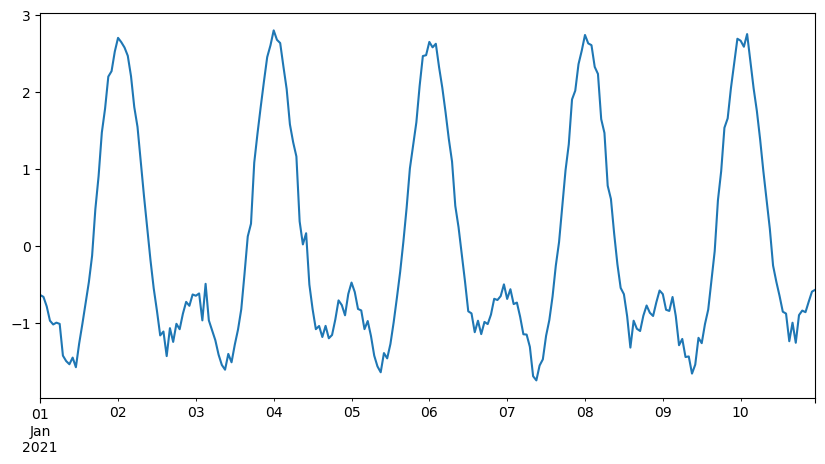

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas

from gluonts.dataset.common import ListDataset
from gluonts.torch import SimpleFeedForwardEstimator
from gluonts.evaluation import make_evaluation_predictions
from gluonts.evaluation import Evaluator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def generate_single_ts(date_range, item_id=None) -> pd.DataFrame:
    """create sum of `n_f` sin/cos curves with random scale and phase."""
    n_f = 2
    period = np.array([24 / (i + 1) for i in range(n_f)]).reshape(1, n_f)
    scale = np.random.normal(1, 0.3, size=(1, n_f))
    phase = 2 * np.pi * np.random.uniform(size=(1, n_f))
    periodic_f = lambda x: scale * np.sin(np.pi * x / period + phase)

    t = np.arange(0, len(date_range)).reshape(-1, 1)
    target = periodic_f(t).sum(axis=1) + np.random.normal(0, 0.1, size=len(t))
    ts = pd.DataFrame({"target": target}, index=date_range)
    if item_id is not None:
        ts["item_id"] = item_id
    return ts

prediction_length, freq = 24, "1H"
T = 10 * prediction_length
date_range = pd.date_range("2021-01-01", periods=T, freq=freq)
ts = generate_single_ts(date_range)

print("ts.shape:", ts.shape)
print(ts.head())
ts.loc[:, "target"].plot(figsize=(10, 5))


In [2]:
from gluonts.torch import DeepAREstimator
from gluonts.evaluation import make_evaluation_predictions, Evaluator


def train_and_predict(dataset, estimator):
    predictor = estimator.train(dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset, predictor=predictor
    )
    evaluator = Evaluator(quantiles=(np.arange(20) / 20.0)[1:], num_workers=0)
    agg_metrics, item_metrics = evaluator(ts_it, forecast_it, num_series=len(dataset))
    return agg_metrics["MSE"]


estimator = DeepAREstimator(
    freq=freq, prediction_length=prediction_length, trainer_kwargs={'max_steps':3,'accelerator':'cpu',})


In [3]:
from gluonts.dataset.pandas import PandasDataset

ds = PandasDataset(ts, target="target", freq=freq)
train_and_predict(ds, estimator)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/user/anaconda3/envs/freqdiff310/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/user/anaconda3/envs/freqdiff310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | In sizes                                                      | Out sizes   
---------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 27.6 K | [[1, 1], [1, 1], [1, 744, 5], [1, 744], [1, 744], [1, 24, 5]] | [1, 100, 24]
---------------------------------------------------------------------------------------------------------------------
27.6 K    Trainable params
0         Non-trainable params
27.6 K    Total params
0.111     Total estimated model params size (MB)


Epoch 0: |          | 3/? [00:00<00:00, 24.74it/s, v_num=24, train_loss=1.870]

Epoch 0, global step 3: 'train_loss' reached 1.86585 (best 1.86585), saving model to '/home/user/workspaces/FrequencyDiffusion/notebooks/lightning_logs/version_24/checkpoints/epoch=0-step=3.ckpt' as top 1
`Trainer.fit` stopped: `max_steps=3` reached.


Epoch 0: |          | 3/? [00:00<00:00, 23.55it/s, v_num=24, train_loss=1.870]


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


1.8235253185226856

In [4]:

N = 10
multiple_ts = [generate_single_ts(date_range) for i in range(N)]

ds = PandasDataset(multiple_ts, target="target", freq=freq)
train_and_predict(ds, estimator)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/user/anaconda3/envs/freqdiff310/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/user/anaconda3/envs/freqdiff310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | In sizes                                                      | Out sizes   
---------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 27.6 K | [[1, 1], [1, 1], [1, 744, 5], [1, 744], [1, 744], [1, 24, 5]] | [1, 100, 24]
---------------------------------------------------------------------------------------------------------------------
27.6 K    Trainable params
0         Non-trainable params
27.6 K    Total params
0.111     Total estimated model params size (MB)


Epoch 0: |          | 3/? [00:00<00:00, 22.00it/s, v_num=25, train_loss=1.600]

Epoch 0, global step 3: 'train_loss' reached 1.60474 (best 1.60474), saving model to '/home/user/workspaces/FrequencyDiffusion/notebooks/lightning_logs/version_25/checkpoints/epoch=0-step=3.ckpt' as top 1
`Trainer.fit` stopped: `max_steps=3` reached.


Epoch 0: |          | 3/? [00:00<00:00, 21.05it/s, v_num=25, train_loss=1.600]


Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 27.77it/s]


0.8586620670121011

In [5]:
ts_in_long_format = pd.concat(
    [generate_single_ts(date_range, item_id=i) for i in range(N)]
)
# ts_in_long_format

# # Note we need an item_id column now and provide its name to the constructor.
# # Otherwise, there is no way to distinguish different time series.
ds = PandasDataset.from_long_dataframe(
    ts_in_long_format, item_id="item_id", target="target", freq=freq
)
train_and_predict(ds, estimator)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/user/anaconda3/envs/freqdiff310/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/user/anaconda3/envs/freqdiff310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | In sizes                                                      | Out sizes   
---------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 27.6 K | [[1, 1], [1, 1], [1, 744, 5], [1, 744], [1, 744], [1, 24, 5]] | [1, 100, 24]
--------------------------------------------------------------------------------------------------------------

Epoch 0: |          | 0/? [00:00<?, ?it/s] 

Epoch 0: |          | 3/? [00:00<00:00, 27.01it/s, v_num=26, train_loss=1.540]

Epoch 0, global step 3: 'train_loss' reached 1.54151 (best 1.54151), saving model to '/home/user/workspaces/FrequencyDiffusion/notebooks/lightning_logs/version_26/checkpoints/epoch=0-step=3.ckpt' as top 1
`Trainer.fit` stopped: `max_steps=3` reached.


Epoch 0: |          | 3/? [00:00<00:00, 25.76it/s, v_num=26, train_loss=1.540]


Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 30.32it/s]


0.8182805381173184

In [6]:
def generate_single_ts_with_features(date_range, item_id) -> pd.DataFrame:
    ts = generate_single_ts(date_range, item_id)
    T = ts.shape[0]
    # static features are constant for each series
    ts["dynamic_real_1"] = np.random.normal(size=T)
    ts["dynamic_real_2"] = np.random.normal(size=T)
    # ... we can have as many static or dynamic features as we like
    return ts


ts = generate_single_ts_with_features(date_range, item_id=0)
ts

,target,item_id,dynamic_real_1,dynamic_real_2
2021-01-01 00:00:00,0.367557,0,0.219205,-1.006652
2021-01-01 01:00:00,0.404260,0,-1.414811,-1.392489
2021-01-01 02:00:00,0.423891,0,-0.027503,-0.429073
2021-01-01 03:00:00,0.404481,0,1.374566,0.539181
2021-01-01 04:00:00,0.364274,0,0.697070,0.961918
...,...,...,...,...
2021-01-10 19:00:00,-0.343222,0,1.313939,0.575888
2021-01-10 20:00:00,-0.022693,0,-0.391024,-0.577072
2021-01-10 21:00:00,0.347139,0,-1.506644,1.074423
2021-01-10 22:00:00,0.397295,0,0.569750,0.625289


In [7]:
estimator_with_features = DeepAREstimator(
    freq=ds.freq,
    prediction_length=prediction_length,
    num_feat_dynamic_real=2,
    num_feat_static_cat=1,
    num_feat_static_real=1,
    cardinality=[
        3,
    ],
    trainer_kwargs={'max_steps':3,'accelerator':'cpu',}
    # trainer=Trainer(epochs=1),
)

In [8]:
multiple_ts = {
    i: generate_single_ts_with_features(date_range, item_id=i) for i in range(N)
}
static_features = pd.DataFrame(
    {
        "color": pd.Categorical(np.random.choice(["red", "green", "blue"], size=N)),
        "height": np.random.normal(loc=100, scale=15, size=N),
    },
    index=list(multiple_ts.keys()),
)
multiple_ts_long = pd.concat(multiple_ts.values())

multiple_ts_dataset = PandasDataset(
    multiple_ts,
    feat_dynamic_real=["dynamic_real_1", "dynamic_real_2"],
    static_features=static_features,
)
# for long-dataset we use a different constructor and need a `item_id` column
multiple_ts_long_dataset = PandasDataset.from_long_dataframe(
    multiple_ts_long,
    item_id="item_id",
    feat_dynamic_real=["dynamic_real_1", "dynamic_real_2"],
    static_features=static_features,
)
static_features

,color,height
0,blue,104.136626
1,blue,94.284978
2,blue,100.128481
3,green,77.262578
4,blue,91.437047
5,red,82.157661
6,red,127.284947
7,green,60.082463
8,red,95.738680
9,green,83.861204


In [9]:
train_and_predict(multiple_ts_dataset, estimator_with_features)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/user/anaconda3/envs/freqdiff310/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/user/anaconda3/envs/freqdiff310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | In sizes                                                      | Out sizes   
---------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 28.1 K | [[1, 1], [1, 1], [1, 744, 7], [1, 744], [1, 744], [1, 24, 7]] | [1, 100, 24]
--------------------------------------------------------------------------------------------------------------

Epoch 0: |          | 3/? [00:00<00:00, 19.95it/s, v_num=27, train_loss=1.620]

Epoch 0, global step 3: 'train_loss' reached 1.61942 (best 1.61942), saving model to '/home/user/workspaces/FrequencyDiffusion/notebooks/lightning_logs/version_27/checkpoints/epoch=0-step=3.ckpt' as top 1
`Trainer.fit` stopped: `max_steps=3` reached.


Epoch 0: |          | 3/? [00:00<00:00, 19.27it/s, v_num=27, train_loss=1.620]


Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 42.38it/s]


1.435222067058141

In [10]:
train_and_predict(multiple_ts_long_dataset, estimator_with_features)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/user/anaconda3/envs/freqdiff310/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/user/anaconda3/envs/freqdiff310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | In sizes                                                      | Out sizes   
---------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 28.1 K | [[1, 1], [1, 1], [1, 744, 7], [1, 744], [1, 744], [1, 24, 7]] | [1, 100, 24]
--------------------------------------------------------------------------------------------------------------

Epoch 0: |          | 3/? [00:00<00:00, 18.07it/s, v_num=28, train_loss=1.780]

Epoch 0, global step 3: 'train_loss' reached 1.78289 (best 1.78289), saving model to '/home/user/workspaces/FrequencyDiffusion/notebooks/lightning_logs/version_28/checkpoints/epoch=0-step=3.ckpt' as top 1
`Trainer.fit` stopped: `max_steps=3` reached.


Epoch 0: |          | 3/? [00:00<00:00, 17.52it/s, v_num=28, train_loss=1.780]


Running evaluation: 100%|██████████| 10/10 [00:00<00:00, 30.60it/s]


1.3706744461259177

In [11]:
train = PandasDataset(
    {item_id: df[:-3*prediction_length] for item_id, df in multiple_ts.items()},
    feat_dynamic_real=["dynamic_real_1", "dynamic_real_2"],
    static_features=static_features,
)

test = PandasDataset(
    multiple_ts,
    feat_dynamic_real=["dynamic_real_1", "dynamic_real_2"],
    static_features=static_features,
)

In [12]:
predictor = estimator_with_features.train(train)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/user/anaconda3/envs/freqdiff310/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/user/anaconda3/envs/freqdiff310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | In sizes                                                      | Out sizes   
---------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 28.1 K | [[1, 1], [1, 1], [1, 744, 7], [1, 744], [1, 744], [1, 24, 7]] | [1, 100, 24]
--------------------------------------------------------------------------------------------------------------

Epoch 0: |          | 3/? [00:00<00:00, 17.72it/s, v_num=29, train_loss=1.670]

Epoch 0, global step 3: 'train_loss' reached 1.67355 (best 1.67355), saving model to '/home/user/workspaces/FrequencyDiffusion/notebooks/lightning_logs/version_29/checkpoints/epoch=0-step=3.ckpt' as top 1
`Trainer.fit` stopped: `max_steps=3` reached.


Epoch 0: |          | 3/? [00:00<00:00, 17.16it/s, v_num=29, train_loss=1.670]


In [19]:
from gluonts.dataset.split import split
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.util import period_index, to_pandas


def _to_dataframe(input_label) -> pd.DataFrame:
    """
    Turn a pair of consecutive (in time) data entries into a dataframe.
    """
    start = input_label[0][FieldName.START]
    targets = [entry[FieldName.TARGET] for entry in input_label]
    full_target = np.concatenate(targets, axis=-1)
    index = period_index({FieldName.START: start, FieldName.TARGET: full_target})
    return pd.DataFrame(full_target.transpose(), index=index)


window_length = predictor.prediction_length + predictor.lead_time
# print(predictor.lead_time)
training_data, test_template = split(test, offset=-3 * window_length)
test_data = test_template.generate_instances(window_length, windows=2 * window_length + 1, distance=1, max_history=window_length)
forecast_it, ts_it = (
    predictor.predict(test_data.input, num_samples=100),
    map(_to_dataframe, test_data),
)
forecasts_pytorch = list(forecast_it)
tss_pytorch = list(ts_it)

evaluator = Evaluator(quantiles=(np.arange(20) / 20.0)[1:], num_workers=0)
agg_metrics, item_metrics = evaluator(tss_pytorch, forecasts_pytorch)

Running evaluation: 490it [00:03, 150.67it/s]


In [18]:
item_metrics

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,...,QuantileLoss[0.75],Coverage[0.75],QuantileLoss[0.8],Coverage[0.8],QuantileLoss[0.85],Coverage[0.85],QuantileLoss[0.9],Coverage[0.9],QuantileLoss[0.95],Coverage[0.95]
0,0,2021-01-08 00:00,0.724931,16.527919,17.553722,0.731405,1.013406,0.679553,0.953573,1.559192,...,12.307343,0.875000,10.941409,0.958333,9.535338,1.000000,7.724808,1.000000,5.157125,1.000000
1,0,2021-01-08 01:00,0.679262,15.986018,17.736067,0.739003,1.007922,0.660849,0.875999,1.515089,...,12.482090,0.916667,11.089779,0.958333,9.724944,1.000000,8.210302,1.000000,5.471453,1.000000
2,0,2021-01-08 02:00,0.676397,17.216761,17.721720,0.738405,1.001412,0.716353,1.037261,1.635890,...,12.595585,0.875000,11.363930,0.916667,9.583450,1.000000,7.658261,1.000000,5.216567,1.000000
3,0,2021-01-08 03:00,0.705593,17.047312,17.546026,0.731084,0.995559,0.713474,1.033324,1.681472,...,12.355034,0.833333,11.215099,0.958333,9.766723,1.000000,7.985700,1.000000,5.461416,1.000000
4,0,2021-01-08 04:00,0.656335,16.209379,17.244549,0.718523,0.989259,0.682724,0.886428,1.552667,...,12.311253,0.916667,10.983494,0.916667,9.394270,1.000000,7.721919,1.000000,5.289974,1.000000
5,1,2021-01-08 00:00,0.537962,15.150515,15.388713,0.641196,1.252697,0.503930,1.556807,1.659295,...,13.804217,1.000000,12.816130,1.000000,11.172144,1.000000,9.024492,1.000000,5.866569,1.000000
6,1,2021-01-08 01:00,0.462824,12.875581,15.018085,0.625754,1.247141,0.430170,1.403961,1.398622,...,13.563750,1.000000,12.567133,1.000000,11.219251,1.000000,9.162633,1.000000,5.864446,1.000000
7,1,2021-01-08 02:00,0.475368,13.963230,14.561311,0.606721,1.241479,0.468636,1.376275,1.588915,...,13.682346,1.000000,13.030948,1.000000,11.471467,1.000000,9.122589,1.000000,5.963617,1.000000
8,1,2021-01-08 03:00,0.352052,11.998916,13.631264,0.567969,1.239399,0.403385,1.464127,1.507794,...,13.211938,1.000000,12.224991,1.000000,10.976226,1.000000,9.042314,1.000000,6.156625,1.000000
9,1,2021-01-08 04:00,0.397126,11.820977,12.962066,0.540086,1.236414,0.398362,1.776623,1.362131,...,13.141296,1.000000,12.417281,1.000000,11.365704,1.000000,9.253060,1.000000,6.211123,1.000000


In [17]:
from itertools import islice


for idx, (forecast, ts) in islice(enumerate(zip(forecasts_pytorch, tss_pytorch)), 9):
    # ax = plt.subplot(3, 3, idx + 1)
    print(ts[-5 * prediction_length :].to_timestamp())
    print(forecast)
    # plt.plot(ts[-5 * prediction_length :].to_timestamp(), label="target")
    # forecast.plot()
    # plt.xticks(rotation=60)
    # ax.xaxis.set_major_formatter(date_formater)

                            0
2021-01-04 00:00:00 -0.452626
2021-01-04 01:00:00 -0.725134
2021-01-04 02:00:00 -0.866961
2021-01-04 03:00:00 -1.406889
2021-01-04 04:00:00 -1.463340
...                       ...
2021-01-08 19:00:00  0.363605
2021-01-08 20:00:00  0.258066
2021-01-08 21:00:00  0.136216
2021-01-08 22:00:00 -0.265441
2021-01-08 23:00:00 -0.310883

[120 rows x 1 columns]
gluonts.model.forecast.SampleForecast(info=None, item_id='0', samples=array([[ 0.5917033 ,  0.17943457,  5.9470663 , ...,  0.1563657 ,
         0.9213214 , -1.089893  ],
       [-0.87291616,  1.1067609 , -1.0934265 , ..., -0.6697999 ,
        -1.4105551 , -1.918352  ],
       [-2.175894  ,  0.6340908 ,  2.8945315 , ...,  0.34995815,
        -0.93104243, -0.73153716],
       ...,
       [-0.72963417, -0.18709742, -0.54057604, ...,  0.49806985,
         4.353466  ,  0.32596883],
       [ 0.12265743, -0.5837308 , -0.06644715, ..., -0.30216372,
        -0.7128781 , -4.8317165 ],
       [ 0.01329204, -1.1261461 , 